In [1]:
import re
import spacy
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import en_core_web_sm
import tensorflow as tf
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from spacy.lang.en.stop_words import STOP_WORDS
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
nlp = en_core_web_sm.load()
lemmatizer = WordNetLemmatizer()
stopwords = STOP_WORDS
EMOJI_PATTERN = re.compile(
    "["
    u"U0001F600-U0001F64F"  # emoticons
    u"U0001F300-U0001F5FF"  # symbols & pictographs
    u"U0001F680-U0001F6FF"  # transport & map symbols
    u"U0001F1E0-U0001F1FF"  # flags (iOS)
    u"U00002702-U000027B0"
    u"U000024C2-U0001F251"
    "]+", flags=re.UNICODE
)
FILTERS = '!"#$%&()*+,-/:;?@[\]^_`{|}~tn'
HTML_TAG_PATTERN = re.compile(r']*>')
NUMBERING_PATTERN = re.compile('d+(?:st|[nr]d|th)')
DISABLE_PIPELINES = ["tok2vec", "parser", "ner", "textcat", "custom", "lemmatizer"]

In [2]:
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 12.0 MB 9.5 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [3]:
# loading the data from the csv file
imdb_data = pd.read_csv('/content/IMDB Dataset.csv', encoding = 'utf-8')
print(imdb_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


In [4]:
import nltk
nltk.download('wordnet')

def initial_preprocessing(text):

  # removes HTML tags, emojis and extra characters
  tag_removed_text = HTML_TAG_PATTERN.sub('', text)
  emoji_removed_text = EMOJI_PATTERN.sub(r'', tag_removed_text)
  numberings_removed_text =  NUMBERING_PATTERN.sub('', emoji_removed_text)
  extra_chars_removed_text = re.sub(r"(.)1{2,}",  r'11', numberings_removed_text)
  return extra_chars_removed_text

def preprocess_text(doc):

  tokens = [token for token in doc if not token.is_space and not token.like_email and not token.like_url and not token.is_stop and 
            not token.is_punct and not token.like_num ]

  # removes special characters in tokens
  translation_table = str.maketrans('', '', FILTERS)
  translated_tokens = [token.text.lower().translate(translation_table) for token in tokens]

  # removes single characters and lemmatize
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in translated_tokens if len(token) > 1]
  return lemmatized_tokens

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [5]:
# preprocessing the text data
text_data = imdb_data.iloc[:, 0]
text_data = text_data.apply(initial_preprocessing)
texts = [preprocess_text(doc) for doc in nlp.pipe(text_data, disable=DISABLE_PIPELINES)]

# extracting the labels
labels = imdb_data['sentiment'].iloc[:]
labels = labels.map(lambda x: 1 if x=='positive' else 0)

In [6]:
tokenizer = Tokenizer(filters=FILTERS, lower=True)

# fitting the tokenizer on texts
tokenizer.fit_on_texts(texts)
vocab_size = len(tokenizer.word_index) + 1
sequences = []
max_sequence_len = 0

# calculating the maximum sequence length
for text in texts:
    # convert texts to sequence
    txt_to_seq = tokenizer.texts_to_sequences([text])[0]
    sequences.append(txt_to_seq)
    # find max_sequence_len for padding
    txt_to_seq_len = len(txt_to_seq)
    if txt_to_seq_len > max_sequence_len:
        max_sequence_len = txt_to_seq_len

# padding all the sentences to equal length
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_len, padding='post')

In [7]:
# splitting the data into train, test and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, labels.values, test_size = 0.2, stratify = labels.values, random_state = 123)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, stratify = y_temp, random_state = 123)
print((len(X_train), len(y_train)))
print((len(X_val), len(y_val)))
print((len(X_test), len(y_test)))

(40000, 40000)
(5000, 5000)
(5000, 5000)


In [8]:
# building the model
model = Sequential()
model.add(Embedding(vocab_size, 64, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(64, return_sequences=True, input_shape=(None, 1))))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
adam = Adam(learning_rate=0.01)
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True), optimizer = adam, metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1264, 64)          6741632   
_________________________________________________________________
bidirectional (Bidirectional (None, 1264, 128)         66048     
_________________________________________________________________
dropout (Dropout)            (None, 1264, 128)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0

In [9]:
# training the model
history = model.fit(padded_sequences, labels.values,  epochs=10, verbose=1, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


782/782 [==============================] - 192s 231ms/step - loss: 0.4372 - accuracy: 0.8026 - val_loss: 0.1995 - val_accuracy: 0.9262
Epoch 2/10
782/782 [==============================] - 179s 229ms/step - loss: 0.2299 - accuracy: 0.9146 - val_loss: 0.1184 - val_accuracy: 0.9596
Epoch 3/10
782/782 [==============================] - 180s 230ms/step - loss: 0.1482 - accuracy: 0.9488 - val_loss: 0.0711 - val_accuracy: 0.9794
Epoch 4/10
782/782 [==============================] - 179s 229ms/step - loss: 0.0932 - accuracy: 0.9688 - val_loss: 0.0452 - val_accuracy: 0.9882
Epoch 5/10
782/782 [==============================] - 179s 229ms/step - loss: 0.0667 - accuracy: 0.9791 - val_loss: 0.0261 - val_accuracy: 0.9946
Epoch 6/10
782/782 [==============================] - 178s 227ms/step - loss: 0.0463 - accuracy: 0.9851 - val_loss: 0.0182 - val_accuracy: 0.9942
Epoch 7/10
782/782 [==============================] - 179s 229ms/step - loss: 0.0383 - accuracy: 0.9885 - val_loss: 0.0185 - val_accura

Text(0.5, 0, 'Epoch')

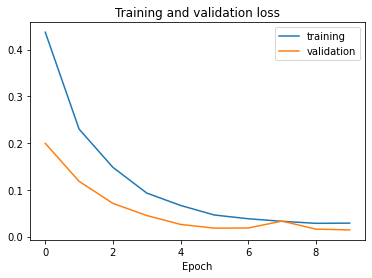

In [12]:
import matplotlib.pyplot as plt

# plotting the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Training and validation loss')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

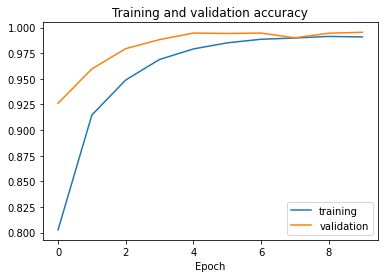

In [13]:
# plotting the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')

In [11]:
# evaluating the model performance
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size = 64)
print('The testing loss is: {} and testing accuracy is: {}'.format(test_loss, test_acc))

79/79 [==============================] - 6s 72ms/step - loss: 0.0161 - accuracy: 0.9956
The testing loss is: 0.01607498899102211 and testing accuracy is: 0.9955999851226807
